In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

In this assignment you are going to see the surprising power of PCA for working with images. 

There is a famous dataset that is commonly used in machine learning called MNIST. It consists of small images of handwritten forms of the digits 0 to 9 for classification. The nice things about MNIST are that the problem is clear, the images are small (so computational time isn't too big), there is lots of data, and the problem is somehow the right level of difficulty. But the images are very boring. So a few years ago somebody produced fashion MNIST -- still tiny images (28 by 28 pixels), but of clothes rather than digits. Maybe more interesting if you like that kind of thing; I don't care, but somehow the images are slightly easier to look at. 

I've put a csv file containing a small part of fashion MNIST (`fmnist_small.csv`) on Blackboard. There are 10 classes, which I can't remember -- some internet searching will soon tell you -- and I've given you 300 of each class.

Each datapoint consists of a unique ID, a class (number 0-9), and then 768 ($=28 \times 28$) greyscale pixel values. 

Task 1: Load the data using `np.genfromtxt`, and plot 10 examples of each of the 10 classes in a little grid (as below). You will need to reshape the vector to make the image and then use `pl.imshow`. I used `pl.subplots` to make the grid. (3 marks)

A quick note: your computer might start to complain about the number of images you have open. If it does, reduce the number of examples in each plot to 5. 

In [22]:
data = np.genfromtxt('../../res/data/fmnist_small.csv', delimiter=' ')

classes = [0,1,2,3,4,5,6,7,8,9]    

img_width = 28
img_height = 28

img_dimensions = img_width * img_height
class_dimension = 1
id_dimension = 1

# data: a 2-D array, the outermost dimension has 3000 rows, each with 786 elements
# vector_long <=> len(data[0])
# vector_long = 786 elements
vector_long = id_dimension + class_dimension + img_dimensions

In [285]:
def plot_images(data, y, title = None, img_width = 28, img_height = 28):
    """
        data: no id, class included.
    """
    
    # plot 10 examples of each of the 10 classes in a little grid
    figure, axes = pl.subplots(10,10)

    if title is not None:
        figure.suptitle(title)
    
    for c in classes:
        indices = np.where(y == c)
        indices_10 = indices[0][:10]
        rows = data[indices_10]
        
        count = 0
        for row in rows:
            cur_img = np.reshape(row, (img_width,img_height))
            axes[c,count].imshow(cur_img, cmap='gray')
            
            if count >= 9:
                continue
            else:
                count += 1

    # hide x labels and tick labels for top plots 
    # and y ticks for right plots.
    for axis in axes.flat:
        axis.label_outer()

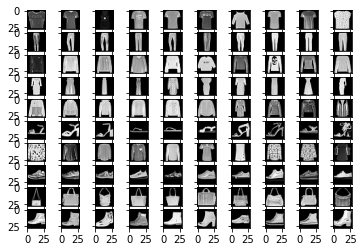

In [287]:
plot_images(data[:, 2:], data[:, 1])

You are going to use PCA on the vector of the data (so the 768 long vector, not the $28 \times 28$ image). You can use either my PCA or the one from sklearn. 

Task 2: Use one of the PCA implementations and make a scree plot of the total explained variance for the first 100 principal components. Use that to decide how many principal components to use. (3 marks)

In [141]:
# Here is PCA which is inspired from my instructor's source code.
def trasform_pca(data):
    # Compute the covariance matrix
    C = np.cov(data.T)

    # Get the eigenvalues and eigenvectors
    evals,evecs = np.linalg.eig(C)

    # Now need to sort them into descending order
    indices = np.argsort(evals)
    indices = indices[::-1]
    evecs = evecs[:,indices]
    evals = evals[indices]

    # Transform the data
    return np.dot(evecs.T,data.T).T, evals, evecs

In [90]:
x = data[:,2:]
y = data[:,1:2].reshape(len(data))

x = x - np.mean(x, axis=0)

(3000, 100)


[Text(0.5, 0, 'Principal Component'), Text(0, 0.5, 'Eigenvalue')]

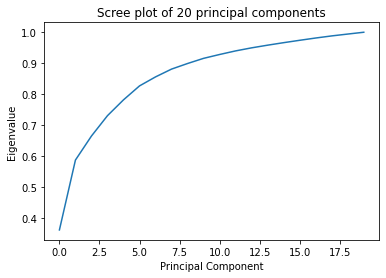

In [340]:
newx, evals, evecs = trasform_pca(x)
print(newx[:,:100].shape)

cumsum = np.cumsum(evals[:20])
explained_variances = cumsum / cumsum[-1]          # <=> cumsum/(sum all evals)

figure, axis = pl.subplots(1,1)
axis.set_title('Scree plot of 20 principal components')

pl.plot(explained_variances)
axis.set(xlabel='Principal Component', ylabel='Eigenvalue')

Comment:

About 95% characteristics of an 28x28 image can be explained by the first 20 principal components. We would choose to use 20 instead of 100 principal components.

Before we do any more with that, let's see how crazy we can get. 

Task 3: Compute the first two principal components, and plot the points in 2D with a different colour for each class. I used `import matplotlib.colors as mcolors` together with the list of colours: `cols = list(mcolors.TABLEAU_COLORS)`. Comment on the results. (3 marks)

In [92]:
def svd_flip(data, evecs):
    """ Inspired by svd_flip from sklearn.utils
        
        data: the output of linalg.svd
        evecs: unitary matrices or eigenvectors
        
        return data_adjusted
    """
    max_abs_cols = np.argmax(np.abs(data), axis=0)
    signs = np.sign(newx[max_abs_cols, range(data.shape[1])])
    data *= signs
    evecs *= signs[:, np.newaxis]
    return data, evecs

(3000, 784)


Text(0, 0.5, 'Component 2')

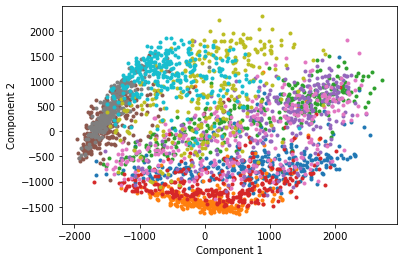

In [338]:
import matplotlib.colors as mcolors

newx, evecs = svd_flip(newx, evecs)

components_1 = newx[:,0]
components_2 = newx[:,1]
print(newx.shape)
cols = list(mcolors.TABLEAU_COLORS)
for class_ in classes:
    indices = np.where(y == class_)
    pl.plot(components_1[indices], components_2[indices], '.', c = cols[class_])

pl.xlabel('Component 1')
pl.ylabel('Component 2')

Comment: 

These two principal components have the high variance as data points are spanning widely from -2000 to over 2500. It matches with the above scree plot which say the first 2 principal components keep a lot of information, roughly 65%.

Task 4: Take the PCA transformed data in 2D, 20D, and 100D, and invert the PCA transformation. Plot the first 10 examples for each class for each of those datasets. (3 marks)

Then make a different set of plots by subtracting the original image from the inverted transformation. This will result in pixel values between -255 and 255. So add 255 to them and divide by 2 to get them back into the correct range. (2 marks) 

In [96]:
def invert(data, evecs):
    """
        data: transformed data(samples, features)
        
        return: inverted data
    """
    data = np.dot(evecs, data.T).T
    return data

In [145]:
newx_2D = newx[:,:2]
evecs_2D = evecs[:2,:2]

newx_2D = invert(newx_2D, evecs_2D)
#plot_images(newx[:,:100], y, 10, 10)

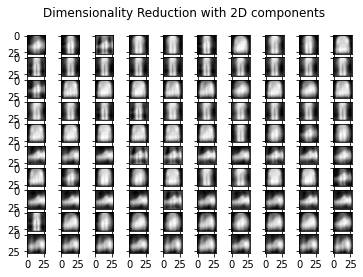

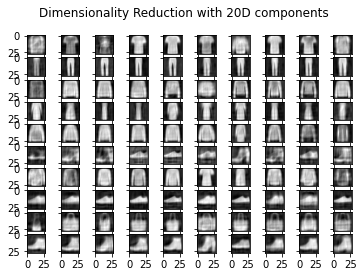

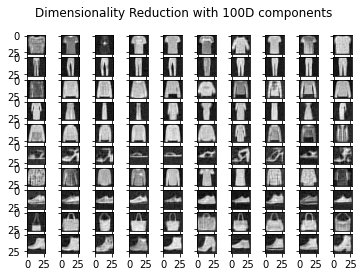

In [181]:
from sklearn.decomposition import PCA

pca = PCA(2)
trans_data = pca.fit_transform(data[:,2:])
inver_data_2 = pca.inverse_transform(trans_data)

plot_images(inver_data_2,y, 'Dimensionality Reduction with 2D components')

pca = PCA(20)
trans_data = pca.fit_transform(data[:,2:])
inver_data_20 = pca.inverse_transform(trans_data)

plot_images(inver_data_20,y, 'Dimensionality Reduction with 20D components')

pca = PCA(100)
trans_data = pca.fit_transform(data[:,2:])
inver_data_100 = pca.inverse_transform(trans_data)

plot_images(inver_data_100,y, 'Dimensionality Reduction with 100D components')

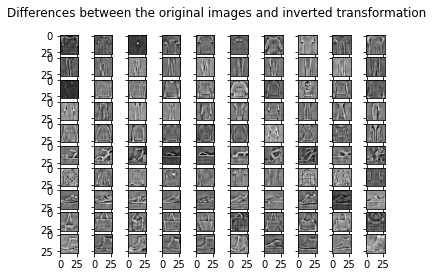

In [343]:
pca = PCA(20)
trans_data = pca.fit_transform(data[:,2:])
inver_data = pca.inverse_transform(trans_data)

result_data = ((data[:,2:] - inver_data) + 255)/2

plot_images(result_data, y, 'Differences between the original images and inverted transformation')

Task 5: Using however many principal components you think best, cluster the data using $k$-means with 10 centres. Plot the usual grid of 10 by 10 for 10 examples of each class. Comment on the results. (3 marks)

In [292]:
from sklearn.cluster import KMeans

pca = PCA(100)
trans_data = pca.fit_transform(data[:,2:])
inver_data = pca.inverse_transform(trans_data)

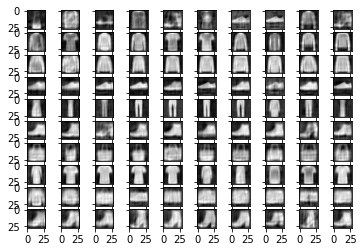

In [319]:
# 1. create kmeans
# 2. fit to the pca-transformed data
# 3. predict new classes/groups
k = 10
kmeans = KMeans(n_clusters = k)
kmeans.fit(trans_data)
labels = kmeans.predict(trans_data)

plot_images(inver_data, labels)

Comment: 

With using 100 principal components and 10 clusters, the accuracy of  this unsupervised clustering model is moderate with some mistakes found. Some images have been detected as a wrong class. For example, some bags have been classified in the high heel group.

$k$-means is an unsupervised method, which makes it hard to compute accuracy metrics. We would have to work out what each class was meant to be and label them appropriately. Instead, we will have a foreward look at a method you will see later in the course, the Support Vector Machine. In sklearn this is avilable using `from sklearn.svm import SVC`. 

We will need to preprocess the data using the `StandardScaler` that we've seen before. 

Task 6: Split the data into 2000 training and 1000 testing images. Then train the SVM using:
- `clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))'
- `clf.fit(training,labels)` 
- `clf.predict(testing)`

Print out the accuracy and the confusion matrix for the classifier. Comment on the results (3 marks)

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pca = PCA(100)
trans_data = pca.fit_transform(data[:,2:])
inver_data = pca.inverse_transform(trans_data)

data_to_split = inver_data

X_train, X_test, y_train, y_test = train_test_split(data_to_split, y, train_size=2000, test_size=1000)

# train the Support Vector Machine (SVM)
svc = SVC(gamma='auto')
classifier = make_pipeline(StandardScaler(), svc)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [342]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

confusion_matrix(y_test, y_pred)

0.833


array([[ 85,   0,   0,  10,   0,   0,   9,   0,   2,   0],
       [  0,  86,   0,   3,   0,   0,   0,   0,   0,   0],
       [  0,   0,  63,   0,  20,   0,   5,   0,   1,   0],
       [  1,   0,   1,  83,   3,   0,   3,   0,   0,   0],
       [  0,   0,   4,   8,  85,   0,   4,   0,   1,   0],
       [  0,   0,   0,   0,   0,  95,   0,   8,   0,   2],
       [ 15,   1,  16,   7,  17,   0,  48,   0,   1,   0],
       [  0,   0,   0,   0,   0,   6,   0,  84,   0,   9],
       [  0,   0,   0,   1,   0,   1,   2,   0, 108,   0],
       [  0,   0,   0,   0,   0,   4,   0,   2,   0,  96]])

Comment: 

The accuracy classification score is roughly 0.8 and there is a good prediction. In other words, there is about 800 images detected correctly over 1000 test images. 

It is more clearly as we see on the 10x10 confusion matrix. The majority of predicted values lies on the diagonal line. 